#Running scAEGAN on simulated data

*   To run scAEGAN within the notebook, you you will need to run autoencoder (AE)first to get the latent representation on both domains 
(A and B) by running:





  



     














In [ ]:
 !python AE.py      --input_file1 Simulated_Data/observed_counts_logNorm_5pop_continuous_A.csv
                    --input_file2 Simulated_Data/observed_counts_logNorm_5pop_continuous_B.csv
                    --output_file1 Simulated_Data/domain_A.csv
                    --output_file2 Simulated_Data/domain_B.csv
                    --batch_size 16 --epochs 200 --dropout_rate 0.2 --learning_rate 0.0001

*  Once we have the output(latent representation from both domains) from the 
autoencoder. Since we are training the cyclegan on all the cells the inference is done on the same number of cells. The next step is to train cyclegan (cGAN) by running:


In [ ]:
 !python cGANtrain.py --data_path Simulated_Data
                      --train_file domain_ --test_file domain_  --save_path Simulated_Data
                      --input_shape 50 --batch_size 4  --epochs 200 

*   After training the cGAN we, will have the two translated output matrix from cGAN (outdataB.csv and outdataA.csv), which will be then used for the analysis by running the R code in the following cells

In [ ]:
library(optparse,  quietly = T)
library(Seurat,    quietly = T)
library(tidyverse, quietly = T)
library(cowplot,   quietly = T)
library(pdfCluster, quietly = T)
library(pheatmap,  quietly = T)
library(clusteval, quietly = T)


In [ ]:
install.packages('Seurat')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘sass’, ‘jquerylib’, ‘sitmo’, ‘globals’, ‘listenv’, ‘parallelly’, ‘plyr’, ‘zoo’, ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘bslib’, ‘spatstat.data’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘abind’, ‘tensor’, ‘goftest’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘RSpectra’, ‘dqrng’, ‘cowplot’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘leiden’, ‘lmtest’, ‘matrixStats’, ‘miniUI’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘RANN’, ‘RcppAnnoy’, ‘reticulate’, ‘ROCR’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘SeuratObject’, ‘shiny’, ‘spatstat.core’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’




In [ ]:
ae.a.file    <- 'Simulated_Data/domain_A.csv'
ae.b.file    <- 'Simulated_Data/domain_B.csv'
A2B.file  <- 'Simulated_Data/outdataB.csv'
B2A.file  <- 'Simulated_Data/outdataA.csv'
# # the input data to the AE
a.file    <- 'Simulated_Data/observed_counts_logNorm_5pop_continuous_A.csv'
b.file    <- 'Simulated_Data/observed_counts_logNorm_5pop_continuous_B.csv'
outDir        <- 'Simulated_Data/'

In [ ]:
cat('Loading data...\n')
print(Sys.time())

ae.A	<- (read.table(ae.a.file, sep = ',', header = T, 
            row.names = 1, stringsAsFactors = F))

ae.B 	<- (read.table(ae.b.file, sep = ',', header = T, 
          row.names = 1, stringsAsFactors = F))

A2B 	<-  (read.table(A2B.file, sep = ',', header = T, 
          row.names = 1, stringsAsFactors = F))

B2A   <-  (read.table(B2A.file, sep = ',', header = T, 
          row.names = 1, stringsAsFactors = F))

a <- (read.table(a.file, sep = ',', header = T, 
            row.names = 1, stringsAsFactors = F))

b   <- (read.table(b.file, sep = ',', header = T, 
          row.names = 1, stringsAsFactors = F))


Loading data...
[1] "2021-06-21 11:35:28 UTC"


In [ ]:

# AE compressed  dataset A
ae.A.seurat <- CreateSeuratObject(
  counts = ae.A, project = "ae.A",
  assay = "RNA", min.cells = 0, min.features = 0, names.field = 1)

ae.A.seurat <- ae.A.seurat %>% 
  FindVariableFeatures() %>% 
  ScaleData() %>% 
  RunPCA(npcs = 20) %>% 
  FindNeighbors(reduction = "pca", dims = 1:20) %>% 
  FindClusters(resolution = 0.6, algorithm = 1) %>% 
  RunUMAP(dims = 1:20)


# AE compressed  dataset B
ae.B.seurat <- CreateSeuratObject(
  counts = ae.B, project = "ae.B",
  assay = "RNA", min.cells = 0, min.features = 0, names.field = 1)
ae.B.seurat <- ae.B.seurat %>% 
  FindVariableFeatures() %>% 
  ScaleData() %>% 
  RunPCA(npcs = 20) %>% 
  FindNeighbors(reduction = "pca", dims = 1:20) %>% 
  FindClusters(resolution = 0.6, algorithm = 1) %>% 
  RunUMAP(dims = 1:20)


# A2B
A2B.seurat <- CreateSeuratObject(
  counts = A2B, project = "A2B",
  assay = "RNA", min.cells = 0, min.features = 0, names.field = 1)
A2B.seurat <- A2B.seurat %>% 
  FindVariableFeatures() %>% 
  ScaleData() %>% 
  RunPCA() %>% 
  FindNeighbors(dims = 1:20) %>% 
  FindClusters(resolution = 0.6) %>% 
  RunUMAP(dims = 1:20)

# add rnaseq clustering to translated dataset
A2B.seurat <- A2B.seurat %>% 
	AddMetaData(Idents(ae.A.seurat), col.name = 'RNAseqID')

# B2A
B2A.seurat <- CreateSeuratObject(
  counts = B2A, project = "B2A",
  assay = "RNA", min.cells = 0, min.features = 0, names.field = 1)
B2A.seurat <- B2A.seurat %>% 
  FindVariableFeatures() %>% 
  ScaleData() %>% 
  RunPCA() %>% 
  FindNeighbors(dims = 1:20) %>% 
  FindClusters(resolution = 0.6) %>% 
  RunUMAP(dims = 1:20)

# add rnaseq clustering to translated dataset
B2A.seurat <- B2A.seurat %>% 
  AddMetaData(Idents(ae.B.seurat), col.name = 'AtacID')

# dataset A
a.seurat <- CreateSeuratObject(
  counts = a, project = "A",
  assay = "RNA", min.cells = 0, min.features = 0, names.field = 1)

a.seurat <- a.seurat %>% 
  FindVariableFeatures() %>% 
  ScaleData() %>% 
  RunPCA(npcs = 20) %>% 
  FindNeighbors(dims = 1:20) %>% 
  FindClusters(resolution = 0.6) %>% 
  RunUMAP(dims = 1:20)

# dataset B
b.seurat <- CreateSeuratObject(
  counts = b, project = "B",
  assay = "RNA", min.cells = 0, min.features = 0, names.field = 1)
b.seurat <- b.seurat %>% 
  FindVariableFeatures() %>% 
  ScaleData() %>% 
  RunPCA(npcs = 20) %>% 
  FindNeighbors(dims = 1:20) %>% 
  FindClusters(resolution = 0.6) %>% 
  RunUMAP(dims = 1:20)

Warning message in eval(predvars, data, env):
“NaNs produced”
Centering and scaling data matrix

Warning message:
“Requested number is larger than the number of available items (50). Setting to 50.”
Warning message:
“Requested number is larger than the number of available items (50). Setting to 50.”
Warning message:
“Requested number is larger than the number of available items (50). Setting to 50.”
Warning message:
“Requested number is larger than the number of available items (50). Setting to 50.”
Warning message:
“Requested number is larger than the number of available items (50). Setting to 50.”
PC_ 1 
Positive:  gene17, gene48, gene40, gene1, gene13, gene46, gene9, gene22, gene24, gene11 
	   gene43, gene25, gene49, gene33, gene38, gene35, gene36, gene20, gene3, gene41 
	   gene5, gene37, gene8, gene12, gene19 
Negative:  gene32, gene31, gene34, gene23, gene14, gene2, gene29, gene21, gene42, gene15 
	   gene26, gene44, gene50, gene4, gene16, gene6, gene27, gene47, gene10, gene18 


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 600
Number of edges: 21188

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8362
Number of communities: 6
Elapsed time: 0 seconds


11:35:33 UMAP embedding parameters a = 0.9922 b = 1.112

11:35:33 Read 600 rows and found 20 numeric columns

11:35:33 Using Annoy for neighbor search, n_neighbors = 30

11:35:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:35:33 Writing NN index file to temp file /tmp/Rtmpg8ebRk/file3b3bdc501b

11:35:33 Searching Annoy index using 1 thread, search_k = 3000

11:35:33 Annoy recall = 100%

11:35:34 Commencing smooth kNN distance calibration using 1 thread

11:35:35 Initializing from normalized Laplacian + noise

11:35:35 Commencing optimization for 500 epochs, with 24666 positive edges

11:35:36 Optimization finished

Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of i

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 600
Number of edges: 23558

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7874
Number of communities: 6
Elapsed time: 0 seconds


11:35:37 UMAP embedding parameters a = 0.9922 b = 1.112

11:35:37 Read 600 rows and found 20 numeric columns

11:35:37 Using Annoy for neighbor search, n_neighbors = 30

11:35:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:35:37 Writing NN index file to temp file /tmp/Rtmpg8ebRk/file3b7723b12e

11:35:37 Searching Annoy index using 1 thread, search_k = 3000

11:35:37 Annoy recall = 100%

11:35:38 Commencing smooth kNN distance calibration using 1 thread

11:35:39 Initializing from normalized Laplacian + noise

11:35:39 Commencing optimization for 500 epochs, with 23528 positive edges

11:35:40 Optimization finished

Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of i

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 600
Number of edges: 20286

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7818
Number of communities: 6
Elapsed time: 0 seconds


11:35:41 UMAP embedding parameters a = 0.9922 b = 1.112

11:35:41 Read 600 rows and found 20 numeric columns

11:35:41 Using Annoy for neighbor search, n_neighbors = 30

11:35:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:35:42 Writing NN index file to temp file /tmp/Rtmpg8ebRk/file3b30badea

11:35:42 Searching Annoy index using 1 thread, search_k = 3000

11:35:42 Annoy recall = 100%

11:35:42 Commencing smooth kNN distance calibration using 1 thread

11:35:43 Initializing from normalized Laplacian + noise

11:35:43 Commencing optimization for 500 epochs, with 23258 positive edges

11:35:45 Optimization finished

Warning message in eval(predvars, data, env):
“NaNs produced”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“number of it

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 600
Number of edges: 19121

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8409
Number of communities: 7
Elapsed time: 0 seconds


11:35:45 UMAP embedding parameters a = 0.9922 b = 1.112

11:35:45 Read 600 rows and found 20 numeric columns

11:35:45 Using Annoy for neighbor search, n_neighbors = 30

11:35:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:35:45 Writing NN index file to temp file /tmp/Rtmpg8ebRk/file3b2d608762

11:35:45 Searching Annoy index using 1 thread, search_k = 3000

11:35:46 Annoy recall = 100%

11:35:46 Commencing smooth kNN distance calibration using 1 thread

11:35:47 Initializing from normalized Laplacian + noise

11:35:47 Commencing optimization for 500 epochs, with 24068 positive edges

11:35:48 Optimization finished

Centering and scaling data matrix

PC_ 1 
Positive:  gene662, gene424, gene86, gene568, gene2200, gene483, gene1547, gene2988, gene822, gene730 
	   

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 600
Number of edges: 22252

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8364
Number of communities: 7
Elapsed time: 0 seconds


11:35:50 UMAP embedding parameters a = 0.9922 b = 1.112

11:35:50 Read 600 rows and found 20 numeric columns

11:35:50 Using Annoy for neighbor search, n_neighbors = 30

11:35:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:35:50 Writing NN index file to temp file /tmp/Rtmpg8ebRk/file3b30b2ec4a

11:35:50 Searching Annoy index using 1 thread, search_k = 3000

11:35:50 Annoy recall = 100%

11:35:50 Commencing smooth kNN distance calibration using 1 thread

11:35:51 Initializing from normalized Laplacian + noise

11:35:51 Commencing optimization for 500 epochs, with 23304 positive edges

11:35:53 Optimization finished

Centering and scaling data matrix

PC_ 1 
Positive:  gene2431, gene2617, gene1867, gene239, gene2141, gene690, gene260, gene1222, gene2248, gene2546 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 600
Number of edges: 23928

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7913
Number of communities: 5
Elapsed time: 0 seconds


11:35:54 UMAP embedding parameters a = 0.9922 b = 1.112

11:35:54 Read 600 rows and found 20 numeric columns

11:35:54 Using Annoy for neighbor search, n_neighbors = 30

11:35:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:35:54 Writing NN index file to temp file /tmp/Rtmpg8ebRk/file3b3f9b1cf5

11:35:54 Searching Annoy index using 1 thread, search_k = 3000

11:35:54 Annoy recall = 100%

11:35:55 Commencing smooth kNN distance calibration using 1 thread

11:35:56 Initializing from normalized Laplacian + noise

11:35:56 Commencing optimization for 500 epochs, with 22964 positive edges

11:35:57 Optimization finished



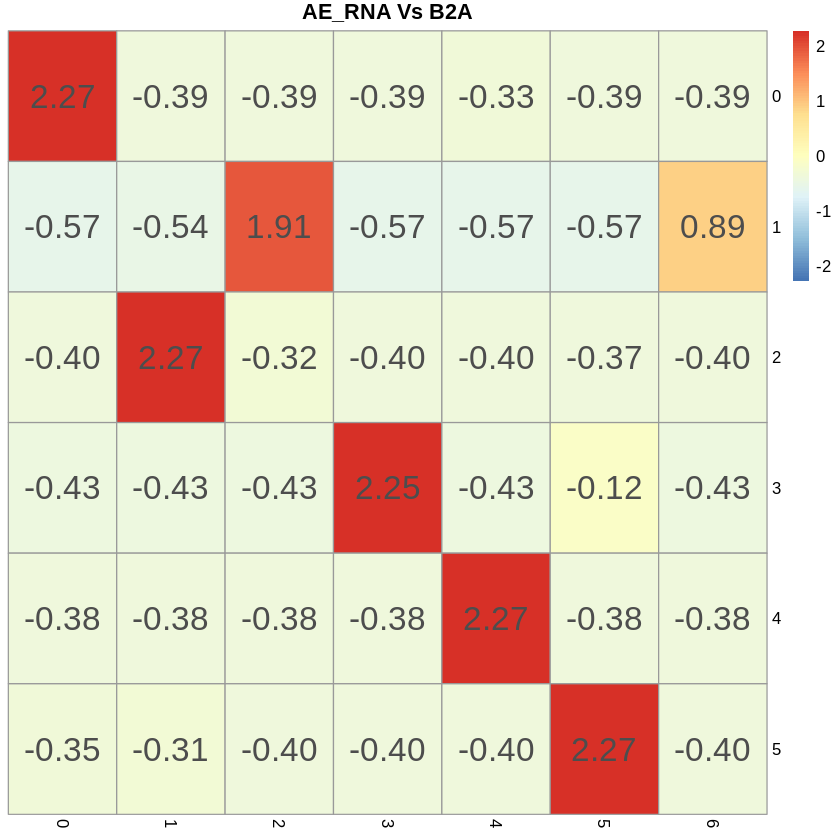

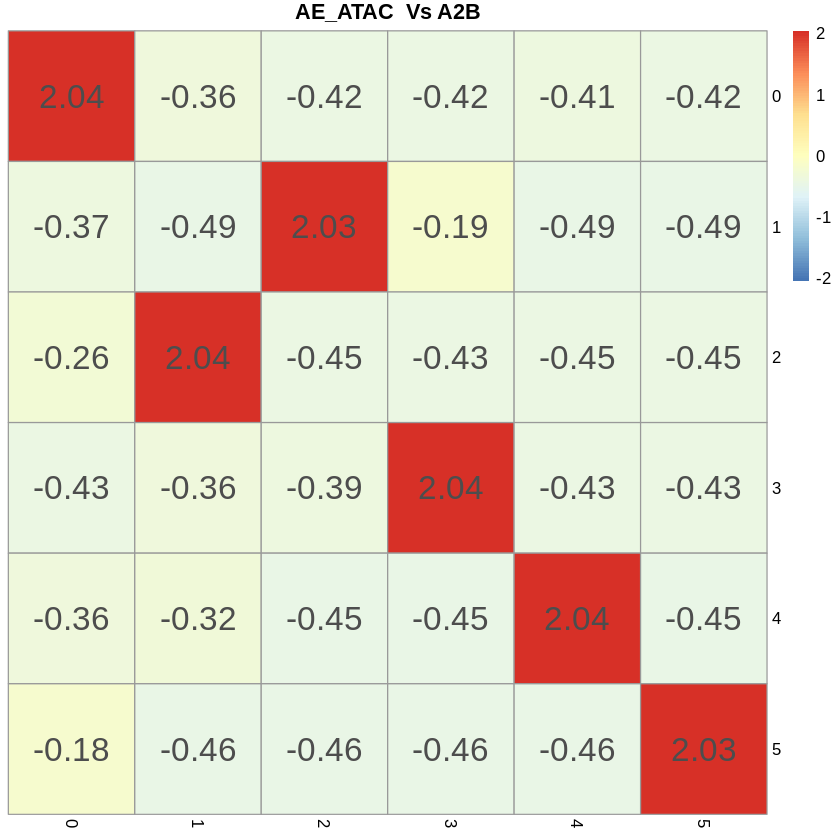

In [ ]:
plts <- list()
plts[["SIMA"]]    <- DimPlot(a.seurat,    reduction = "umap", label = TRUE)
plts[["SIMB"]]      <- DimPlot(b.seurat,    reduction = "umap", label = TRUE)
plts[["AE_SIMA"]] <- DimPlot(ae.A.seurat, reduction = "umap", label = TRUE)
plts[["AE_SIMB"]]   <- DimPlot(ae.B.seurat, reduction = "umap", label = TRUE)
plts[["A2B"]]       <- DimPlot(A2B.seurat,  reduction = "umap", label = TRUE)
plts[["B2A"]]       <- DimPlot(B2A.seurat,  reduction = "umap", label = TRUE)

idx <- c(1,3,5,2,4,6)
p.vae.grid  <- plot_grid(plotlist = plts[idx], nrow = 2, ncol = 3, labels = names(plts)[idx])
ggsave(file.path(outDir, paste0( 'CycleGan_in_vs_reconst.pdf')), p.vae.grid,
	width = 30, height = 16, units = "cm")

# plot heatmaps of cluster similarity
scale.type <- 'row'
ae.B2A.vs.RNAseq.tab 	 <- table(Idents(ae.A.seurat), Idents(B2A.seurat))
ae.B2A.vs.RNAseq.heatmap <- pheatmap(ae.B2A.vs.RNAseq.tab, cluster_rows = F, cluster_cols = F, 
    						display_numbers = T, scale = scale.type, fontsize_number = 20,
                main = 'AE_RNA Vs B2A')

ae.A2B.vs.atac.tab 	 	 <- table(Idents(ae.B.seurat), Idents(A2B.seurat))
ae.A2B.vs.atac.heatmap 	 <- pheatmap(ae.A2B.vs.atac.tab, cluster_rows = F, cluster_cols = F, 
    						display_numbers = T, scale = scale.type, fontsize_number = 20,
                main = 'AE_ATAC  Vs A2B')

p.vae.grid  <- plot_grid(plotlist = list(ae.B2A.vs.RNAseq.heatmap[[4]], ae.A2B.vs.atac.heatmap[[4]]), 
					nrow = 1, ncol = 2, label_size = 10)
ggsave(file.path(outDir, paste0( 'cGANtranslated_vs_inputClass_heatmap.pdf')), p.vae.grid,
	width = 22, height = 10, units = "cm")


In [ ]:

joint.var.feats <- intersect(intersect(intersect(VariableFeatures(ae.A.seurat), VariableFeatures(ae.B.seurat)),
  VariableFeatures(A2B.seurat)), VariableFeatures(B2A.seurat))
cat('found', length(joint.var.feats),' joint variable features...\n')
feature.idx.A <- match(joint.var.feats, rownames(ae.A.seurat@assays$RNA@scale.data))
feature.idx.B <- match(joint.var.feats, rownames(ae.B.seurat@assays$RNA@scale.data))
feature.idx.A2B <- match(joint.var.feats, rownames(A2B.seurat@assays$RNA@scale.data))
feature.idx.B2A <- match(joint.var.feats, rownames(B2A.seurat@assays$RNA@scale.data))

# label transfer BEFORE integration
cellIds.Pred <- classifyNew.SVM(ae.A.seurat@assays$RNA@scale.data[feature.idx.A,], Idents(ae.A.seurat), 
  as.data.frame(ae.B.seurat@assays$RNA@scale.data[feature.idx.B,]), 
  kernel = 'linear', scale = F)
ae.A.vs.B.adj.rand  <- adj.rand.index(Idents(ae.B.seurat),     cellIds.Pred$pop)
ae.A.vs.B.ji        <- cluster_similarity(Idents(ae.B.seurat), cellIds.Pred$pop)

cellIds.Pred <- classifyNew.SVM(ae.B.seurat@assays$RNA@scale.data[feature.idx.B,], Idents(ae.B.seurat), 
  as.data.frame(ae.A.seurat@assays$RNA@scale.data[feature.idx.A,]), 
  kernel = 'linear', scale = F)
ae.B.vs.A.adj.rand  <- adj.rand.index(Idents(ae.A.seurat), cellIds.Pred$pop)
ae.B.vs.A.ji        <- cluster_similarity(Idents(ae.A.seurat), cellIds.Pred$pop)

# label transfer AFTER integration
cat('check integration result A to B2A...\n')
cellIds.Pred <- classifyNew.SVM(ae.A.seurat@assays$RNA@scale.data[feature.idx.A,], Idents(ae.A.seurat), 
  as.data.frame(B2A.seurat@assays$RNA@scale.data[feature.idx.B2A,]), 
  kernel = 'linear', scale = F)
ae.A.vs.B2A.adj.rand  <- adj.rand.index(Idents(ae.A.seurat), cellIds.Pred$pop)
ae.A.vs.B2A.ji        <- cluster_similarity(Idents(ae.A.seurat), cellIds.Pred$pop)

# inA.vs.B2.class <- table(Idents(ae.A.seurat), cellIds.Pred$pop)
# cross.class.plt  <- pheatmap(inA.vs.generatedA.class, cluster_rows = F, cluster_cols = F, 
#     scale = 'none', display_numbers = T)

# ggsave(file.path(outDir, paste0(prefix, 'domain1_to_2_crossClassSVM.pdf')), cross.class.plt,
#   width = 10, height = 8, units = "cm")

cat('check integration result B to A2B...\n')
cellIds.Pred <- classifyNew.SVM(ae.B.seurat@assays$RNA@scale.data[feature.idx.B,], Idents(ae.B.seurat), 
  as.data.frame(A2B.seurat@assays$RNA@scale.data[feature.idx.A2B,]), 
  kernel = 'linear', scale = F)
ae.B.vs.A2B.adj.rand  <- adj.rand.index(Idents(ae.B.seurat), cellIds.Pred$pop)
ae.B.vs.A2B.ji        <- cluster_similarity(Idents(ae.B.seurat), cellIds.Pred$pop)




#######################################
# check ajusted rand index of integrated data clustering vs. input data clusterings

cat("########## RESULT ##########\n")
cat("# Label transfer across domain with SVM\n")
cat("\nBEFORE integration: \nARI ae.A vs. ae.B: ", ae.A.vs.B.adj.rand, 
  "\nARI ae.B vs. ae.A: ",  ae.B.vs.A.adj.rand, 
  "\nJI ae.A vs. ae.B: ",   ae.A.vs.B.ji, 
  "\nJI ae.B vs. ae.A: ",   ae.B.vs.A.ji, "\n")
cat("\nAFTER integration: \nARI ae.A vs. ae.B2A: ", ae.A.vs.B2A.adj.rand, 
  "\nARI ae.B vs. ae.A2B: ",  ae.B.vs.A2B.adj.rand, 
  "\nJI ae.A vs. ae.B2A: ",   ae.A.vs.B2A.ji, 
  "\nJI ae.B vs. ae.A2B: ",   ae.B.vs.A2B.ji, "\n")

cat('Done...\n')
print(Sys.time())

ERROR: ignored

In [ ]:
cellIds.Pred <- classifyNew.SVM(ae.A.seurat@assays$RNA@scale.data, Idents(ae.A.seurat), 
  as.data.frame(B2A.seurat@assays$RNA@scale.data), 
  kernel = 'linear', scale = F)

training data:  50 genes /  600  cells
new data:  50 genes /  600  cells
training SVM...
predicting...


In [ ]:
ae.A.vs.B2A.adj.rand  <- adj.rand.index(Idents(ae.A.seurat), cellIds.Pred$pop)
ae.A.vs.B2A.ji        <- cluster_similarity(Idents(ae.A.seurat), cellIds.Pred$pop)

In [ ]:
cellIds.Pred <- classifyNew.SVM(ae.B.seurat@assays$RNA@scale.data, Idents(ae.B.seurat), 
  as.data.frame(A2B.seurat@assays$RNA@scale.data), 
  kernel = 'linear', scale = F)
ae.B.vs.A2B.adj.rand <- adj.rand.index(Idents(ae.B.seurat), cellIds.Pred$pop)
ae.B.vs.A2B.ji <- cluster_similarity(Idents(ae.B.seurat), cellIds.Pred$pop)



training data:  50 genes /  600  cells
new data:  50 genes /  600  cells
training SVM...
predicting...


In [ ]:
cat("########## RESULT ##########\n")
cat("\nAFTER integration: \nARI ae.A vs. ae.B2A: ", ae.A.vs.B2A.adj.rand, 
  "\nARI ae.B vs. ae.A2B: ",  ae.B.vs.A2B.adj.rand, 
  "\nJI ae.A vs. ae.B2A: ",   ae.A.vs.B2A.ji, 
  "\nJI ae.B vs. ae.A2B: ",   ae.B.vs.A2B.ji, "\n")

cat('Done...\n')
print(Sys.time())

########## RESULT ##########

AFTER integration: 
ARI ae.A vs. ae.B2A:  0.9475734 
ARI ae.B vs. ae.A2B:  0.8432398 
JI ae.A vs. ae.B2A:  0.9182016 
JI ae.B vs. ae.A2B:  0.7789649 
Done...
[1] "2021-06-21 12:01:20 UTC"
